In [275]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform Marr-Hildreth edge detection with hysteresis thresholding
def marr_hildreth_edge_detection(image, lower_threshold, higher_threshold, sigma=1.0):
    """
    Performs Marr-Hildreth edge detection with hysteresis thresholding.

    Args:
        image: Grayscale input image (2D array).
        lower_threshold: Lower threshold for hysteresis.
        higher_threshold: Higher threshold for hysteresis.
        sigma: Standard deviation for Gaussian smoothing.

    Returns:
        edges: Binary edge map.
    """
    # Step 1: Smooth the image using a Gaussian filter
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smoothed_image = cv2.GaussianBlur(image, (0, 0), sigma)

    # Step 2: Compute the Laplacian of the smoothed image
    laplacian = cv2.Laplacian(smoothed_image, cv2.CV_64F)

    # Step 3: Detect zero-crossings
    zero_crossings = np.zeros_like(laplacian, dtype=np.uint8)
    rows, cols = laplacian.shape
    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            neighbors = laplacian[row - 1:row + 2, col - 1:col + 2].flatten()
            if (laplacian[row, col] > 0 and np.any(neighbors < 0)) or \
               (laplacian[row, col] < 0 and np.any(neighbors > 0)):
                zero_crossings[row, col] = 255

    # Step 4: Compute gradient magnitude for hysteresis thresholding
    sobelx = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)

    # Step 5: Apply hysteresis thresholding
    edges = np.zeros_like(image, dtype=np.uint8)
    strong_edges = (gradient_magnitude > higher_threshold)
    weak_edges = (gradient_magnitude > lower_threshold) & ~strong_edges

    edges[strong_edges] = 255

    # Connect weak edges to strong edges
    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            if weak_edges[row, col] and np.any(edges[row - 1:row + 2, col - 1:col + 2] == 255):
                edges[row, col] = 255

    return edges



In [276]:
def extract_edge_coordinates(edge_map):
    # Get the coordinates of edge pixels
    edge_coords = np.column_stack(np.where(edge_map == 255))
    return edge_coords

In [277]:
def encode_pixel_values(image, edge_coords, subsample_distance, quantization_level):
    """
    Encodes pixel values from both sides of the edges.

    Args:
        image (numpy.ndarray): Grayscale image.
        edge_coords (list of tuples): Edge pixel coordinates [(y, x), ...].
        subsample_distance (int): Distance between sampled pixels along the edge.
        quantization_level (int): Number of quantization levels (2^q).

    Returns:
        subsampled_values (list): List of quantized pixel values as tuples [(left, right), ...].
    """
    # List to hold the quantized pixel values
    encoded_values = []
    quantization_level = 2**quantization_level
    # Iterate through edge coordinates
    for coord in edge_coords:
        y, x = coord

        # Extract pixel values from both sides of the edge
        left_pixel = image[y, x - 1] if x - 1 >= 0 else image[y, x]  # Left of the edge
        right_pixel = image[y, x + 1] if x + 1 < image.shape[1] else image[y, x]  # Right of the edge

        # Apply uniform quantization
        # quantized_left = np.round(left_pixel / (256 / quantization_level)) * (256 / quantization_level)
        # quantized_right = np.round(right_pixel / (256 / quantization_level)) * (256 / quantization_level)
        step_size = 256 // quantization_level

    # Quantize the array
        quantized_left = (left_pixel // step_size) * step_size
        quantized_left = np.clip(quantized_left, 0, 255)  # Ensure values remain within range
        quantized_left = quantized_left.astype(np.uint8)
        quantized_right = (right_pixel // step_size) * step_size
        quantized_right = np.clip(quantized_right, 0, 255)  # Ensure values remain within range
        quantized_right = quantized_right.astype(np.uint8)
        # Store the quantized values
        encoded_values.append((quantized_left, quantized_right))

    # Subsample the pixel values (every d-th value along the edge)
    subsampled_values = encoded_values[::subsample_distance]
    # print(subsampled_values[0])
    return subsampled_values


In [278]:
def compress_quantized_list(quantized_list, q):
    """
    Compresses a list of quantized values by encoding only the first q bits of each value.

    Parameters:
    quantized_list (np.ndarray): Array of quantized values.
    q (int): Number of significant bits used in quantization.

    Returns:
    bytes: Compressed bitstream with a header including q and the list length.
    """
    # Store q as the first 4 bits and the length of the list as the next 12 bits
    length = len(quantized_list)
    header = f"{q:04b}{length:032b}"  # 4 bits for q, 12 bits for length

    # Convert each quantized value to its q-bit representation
    compressed_bits = header
    for value in quantized_list:
        compressed_bits += f"{value >> (8 - q):0{q}b}"  # Keep only the q most significant bits

    # Convert bitstring to bytes
    byte_array = bytearray()
    for i in range(0, len(compressed_bits), 8):
        byte_chunk = compressed_bits[i:i + 8]
        byte_array.append(int(byte_chunk.ljust(8, '0'), 2))  # Pad to 8 bits if needed

    return bytes(byte_array)

def decompress_quantized_list(compressed_data):
    """
    Decompresses a bitstream to retrieve the original quantized values.

    Parameters:
    compressed_data (bytes): Compressed bitstream.

    Returns:
    tuple: (np.ndarray, int) Decompressed list of quantized values and the quantization level q.
    """
    # Convert bytes to bitstring
    bitstring = "".join(f"{byte:08b}" for byte in compressed_data)

    # Extract q from the first 4 bits and length from the next 12 bits
    q = int(bitstring[:4], 2)
    length = int(bitstring[4:36], 2)

    # Extract the q-bit values
    quantized_values = []
    start_index = 36
    for i in range(start_index, start_index + length * q, q):
        value_q_bits = int(bitstring[i:i + q], 2)
        quantized_values.append(value_q_bits << (8 - q))  # Shift back to original scale

    return np.array(quantized_values, dtype=np.uint8), q



In [279]:
import numpy as np
import zlib
import pickle

# Step 1: Delta Encoding
def delta_encode(data):
    delta = np.diff(data, axis=0)
    return np.concatenate(([data[0]], delta))

# Step 2: Compress the delta-encoded data using zlib
def compress_data(data):
    serialized_data = pickle.dumps(data)  # Serialize the data to bytes
    compressed_data = zlib.compress(serialized_data)  # Compress with zlib
    return compressed_data

# Step 3: Decompress and Decode the data
def decompress_data(compressed_data):
    decompressed_data = zlib.decompress(compressed_data)  # Decompress the data
    decoded_data = pickle.loads(decompressed_data)  # Deserialize the data back
    return decoded_data

def delta_decode(decoded_data):
    initial_value = decoded_data[0]
    delta_values = decoded_data[1:]
    return np.concatenate(([initial_value], np.cumsum(delta_values) + initial_value))

# # Reconstruct the original coordinates
# original_x = delta_decode(decompressed_x, edge_data[0, 0])
# original_y = delta_decode(decompressed_y, edge_data[0, 1])

# # Reconstructed edge data
# reconstructed_edge_data = np.column_stack((original_x, original_y))

# print("Original Edge Data:\n", edge_data)
# print("Reconstructed Edge Data:\n", reconstructed_edge_data)


In [280]:
import numpy as np

def flatten_list(input_list, is_color):
    """
    Flatten the list of tuples containing 1D numpy arrays into a single list.
    If is_color is False, use only one value for grayscale images.

    Parameters:
    input_list (list): List of tuples where each element is a tuple of two 1D numpy arrays.
    is_color (bool): Flag indicating if the image is color or grayscale.

    Returns:
    list: Flattened list of values.
    """
    flattened_list = []

    for tuple_element in input_list:
        for array in tuple_element:
            if is_color:
                flattened_list.extend(array)  # Add all 3 color values
            else:
                flattened_list.append(array[0])  # Add only the grayscale value once
    # print('-'*50)
    # print(len(flattened_list))
    # print(flattened_list)
    # print('-'*50)
    return flattened_list

def reverse_flattened_list(flattened_list, is_color):
    """
    Reverse the flattened list back to the original format (list of tuples).
    If is_color is False, expand the grayscale value back to 3 identical values.

    Parameters:
    flattened_list (list): The flattened list of values.
    is_color (bool): Flag indicating if the image is color or grayscale.

    Returns:
    list: List of tuples containing 1D numpy arrays.
    """
    # print("-"*50)
    # print(len(flattened_list))
    # print(flattened_list)
    output_list = []
    index = 0
    while index < len(flattened_list):
        # If grayscale, expand the single value into 3 values
        if is_color:
            array1 = np.array(flattened_list[index:index + 3])
            array2 = np.array(flattened_list[index + 3:index + 6])
            output_list.append((array1, array2))
            index += 6
        else:
            value = flattened_list[index]
            array1 = np.array([value, value, value])
            array2 = np.array([value, value, value])
            output_list.append((array1, array2))
            index += 1

    return output_list

In [281]:
import numpy as np

def write_to_file(file_path, compressed_x, compressed_y, compressed_data, is_color, q, d, h, w):
    # Open the file in binary write mode
    with open(file_path, 'wb') as f:
        # Write the size of compressed_x and compressed_y (32 bits)
        f.write(np.uint32(len(compressed_x)).tobytes())  # 4 bytes for compressed_x size
        f.write(np.uint32(len(compressed_y)).tobytes())  # 4 bytes for compressed_y size

        # Write the image color information (is_color), q, and d (8 bits each)
        f.write(np.uint8(is_color).tobytes())  # 1 byte for is_color
        f.write(np.uint8(q).tobytes())  # 1 byte for q
        f.write(np.uint8(d).tobytes())  # 1 byte for d

        # Write the height and width (2 bytes each)
        f.write(np.uint16(h).tobytes())  # 2 bytes for height
        f.write(np.uint16(w).tobytes())  # 2 bytes for width

        # Write the actual compressed_x and compressed_y
        f.write(compressed_x)
        f.write(compressed_y)

        # Write the compressed_data
        f.write(compressed_data)

def read_from_file(file_path):
    with open(file_path, 'rb') as f:
        # Read the size of compressed_x and compressed_y (32 bits)
        len_x = np.frombuffer(f.read(4), dtype=np.uint32)[0]
        len_y = np.frombuffer(f.read(4), dtype=np.uint32)[0]

        # Read the is_color, q, and d values (8 bits each)
        is_color = np.frombuffer(f.read(1), dtype=np.uint8)[0]
        q = np.frombuffer(f.read(1), dtype=np.uint8)[0]
        d = np.frombuffer(f.read(1), dtype=np.uint8)[0]

        # Read the height and width (2 bytes each)
        h = np.frombuffer(f.read(2), dtype=np.uint16)[0]
        w = np.frombuffer(f.read(2), dtype=np.uint16)[0]

        # Read the actual compressed_x and compressed_y data based on their lengths
        compressed_x = f.read(len_x)
        compressed_y = f.read(len_y)

        # Read the compressed_data (its length is encoded in itself, so we don't need to worry about its size)
        compressed_data = f.read()  # Read the rest of the file as compressed_data

    return compressed_x, compressed_y, compressed_data, is_color, q, d, h, w


In [282]:
def compressing_subsampled_values(subsampled_values, edge_coords, is_color, q, d, file_path, h, w):
    edge_data = edge_coords[::d]
    single_list_of_colors = flatten_list(subsampled_values, is_color)
    compressed_data = compress_quantized_list(single_list_of_colors, q)
    delta_x = delta_encode(edge_data[:, 0])
    delta_y = delta_encode(edge_data[:, 1])
    compressed_x = compress_data(delta_x)
    compressed_y = compress_data(delta_y)
    write_to_file(file_path, compressed_x, compressed_y, compressed_data, is_color, q, d, h, w)
    return

def decompressing_subsampled_values(file_path):
    compressed_x, compressed_y, compressed_data, is_color, q, d, h , w = read_from_file(file_path)
    decompressed_x = decompress_data(compressed_x)
    decompressed_y = decompress_data(compressed_y)
    original_x = delta_decode(decompressed_x)
    original_y = delta_decode(decompressed_y)
    edge_coords = np.column_stack((original_x, original_y))
    subsample_values, q = decompress_quantized_list(compressed_data)
    subsampled_values = reverse_flattened_list(subsample_values, is_color)
    return edge_coords, subsampled_values, is_color, q, d, h , w


In [283]:
def get_u0(edge_coords, subsampled_values, h, w, c):
    sampled_image = np.zeros((h, w, c), dtype=np.uint8)

    # Iterate through edge coordinates and place encoded pixel values
    for idx, coord in enumerate(edge_coords):
        y, x = coord
        quantized_left, quantized_right = subsampled_values[idx]
        sampled_image[y, x - 1 if x - 1 >= 0 else x] = quantized_left
        sampled_image[y, x + 1 if x + 1 < image.shape[1] else x] = quantized_right
    return sampled_image

In [284]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
def homogeneous_diffusion(image, max_iterations=10001, tol=1e-5):
    """
    Performs homogeneous diffusion to fill missing values in a 3D image (e.g., RGB).

    Args:
        image (numpy.ndarray): Input image (H x W x C) with missing values (zeros) to be filled.
        max_iterations (int): Maximum number of iterations for the diffusion process.
        tol (float): Convergence tolerance for steady-state solution.

    Returns:
        list: List of images after applying diffusion at specific intervals.
    """
    # Normalize the input image to [0, 1]
    u = image.astype(np.float64) / 255.0
    l = []  # List to store intermediate results

    # Mask of known values (Dirichlet boundary conditions) for each channel
    boundary_mask = (u != 0)  # Boolean mask for each channel

    # Initialize iteration variables
    iteration = 0
    diff = tol + 1  # Initialize with a value larger than tol

    for iteration in tqdm(range(max_iterations)):
        # Create a copy of the current state for comparison
        u_prev = u.copy()

        # Compute the update term using `u_prev` for all channels
        update_term = (
            u_prev[2:, 1:-1, :] + u_prev[:-2, 1:-1, :] +  # Vertical neighbors
            u_prev[1:-1, 2:, :] + u_prev[1:-1, :-2, :] -  # Horizontal neighbors
            4 * u_prev[1:-1, 1:-1, :]                     # Central pixel
        )

        # Update `u` where `boundary_mask` is False
        u[1:-1, 1:-1, :] += 0.1 * update_term * (~boundary_mask[1:-1, 1:-1, :])

        # Clip values to [0, 1]
        u = np.clip(u, 0, 1)

        # Compute the maximum change across all pixels and channels
        diff = np.max(np.abs(u - u_prev))

        # Save intermediate images at specific intervals
        if iteration % 1000 == 0:
            l.append(u.copy())

        # Break if the change is smaller than the tolerance

    print(f"Diffusion converged after {iteration} iterations with diff = {diff:.5f}")
    return l





100%|██████████| 10001/10001 [01:14<00:00, 134.59it/s]


Diffusion converged after 10000 iterations with diff = 0.00001


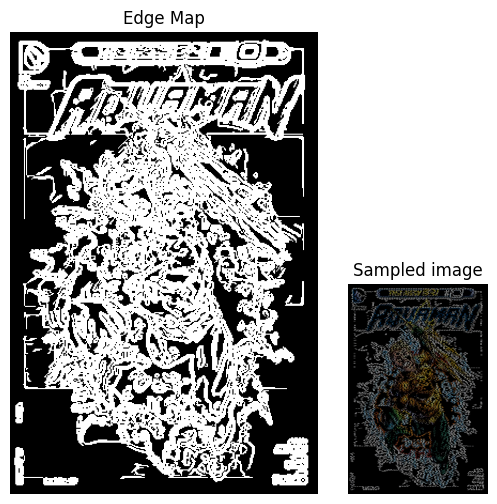

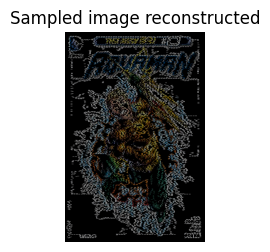

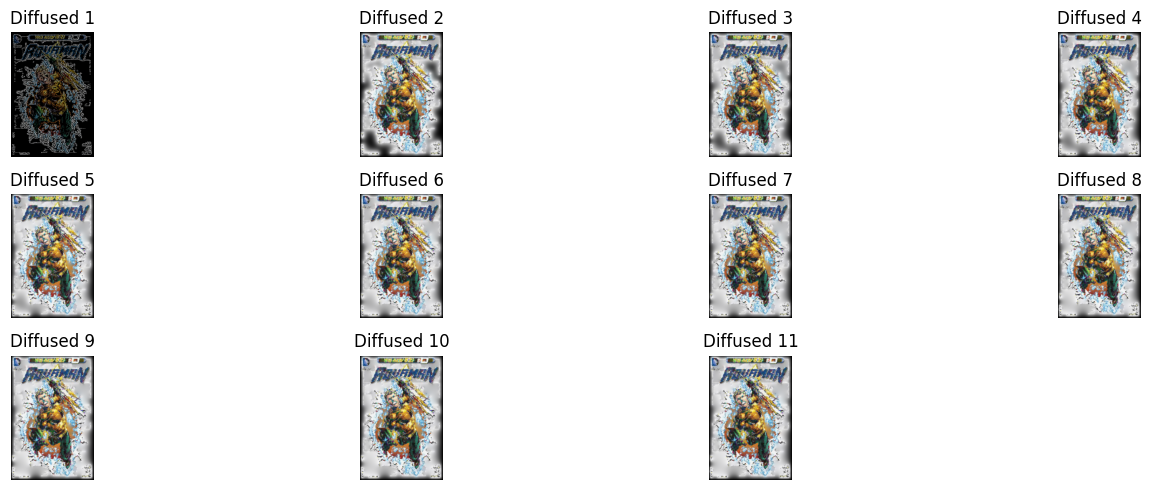

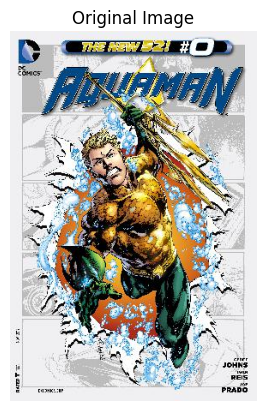

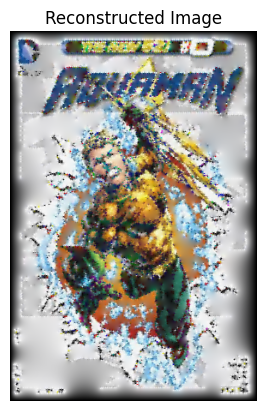

In [285]:
from tqdm import tqdm
def compress_image(image, low_threshold, high_threshold, subsample_distance, quantization_level, file_path):
    # Step 1: Edge Detection
    is_color = len(image.shape) == 3
    edge_map = marr_hildreth_edge_detection(image, low_threshold, high_threshold)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(edge_map, cmap='gray')
    plt.title("Edge Map")
    plt.axis('off')

    # Step 2: Extract Edge Coordinates
    edge_coords = extract_edge_coordinates(edge_map)
    edge_coords_image = np.zeros_like(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    for y, x in edge_coords:
        edge_coords_image[y, x] = 255

    # Step 3: Encode Pixel Values Along the Edge
    subsampled_values = encode_pixel_values(image, edge_coords, subsample_distance, quantization_level)
    c = 0
    if(is_color):
      c = 3
    sampled_image = get_u0(edge_coords[::subsample_distance], subsampled_values, image.shape[0], image.shape[1], c)
    plt.subplot(2, 1, 2)
    plt.imshow(cv2.cvtColor(sampled_image, cv2.COLOR_BGR2RGB))
    plt.title("Sampled image")
    plt.axis('off')
    compressing_subsampled_values(subsampled_values, edge_coords, is_color, quantization_level, subsample_distance, file_path, image.shape[0], image.shape[1])

def decompress_image(file_path):
    edge_coords, subsampled_values, is_color, quantization_level, subsample_distance, h, w = decompressing_subsampled_values(file_path)
    c = 0
    if(is_color):
        c = 3
    sampled_image = get_u0(edge_coords, subsampled_values, h, w, c)
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 2)
    plt.imshow(cv2.cvtColor(sampled_image, cv2.COLOR_BGR2RGB))
    plt.title("Sampled image reconstructed")
    plt.axis('off')
    diffused_images = homogeneous_diffusion(sampled_image)  # Get the list of images

    # Determine the number of images
    num_images = len(diffused_images)

    # Create subplots with an appropriate layout
    plt.figure(figsize=(15, 5))  # Adjust figure size as needed
    rows = (num_images + 3) // 4  # Calculate rows assuming 4 images per row

    for idx, image in enumerate(diffused_images):
        plt.subplot(rows, 4, idx + 1)  # Create subplots (4 images per row)
        image = (image * 255).astype(np.uint8)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Display the image in grayscale
        plt.title(f"Diffused {idx + 1}")  # Add a title for each image
        plt.axis('off')  # Turn off axes for clarity

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()
    return diffused_images[-1]

# Example usage
image = cv2.imread('/content/aquaman.jpg')
low_threshold = 64
high_threshold = 128
subsample_distance = 5
quantization_level = 5
file_path = '/content/compressed.bin'
compress_image(
    image, low_threshold, high_threshold, subsample_distance, quantization_level, file_path
)

decoded_image = decompress_image(file_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

plt.imshow(image_rgb)
plt.axis('off')  # Hide axes for better display
plt.title('Original Image')  # Add a title
plt.show()

decoded_image = (decoded_image * 255).astype(np.uint8)
image_rgb_recons = cv2.cvtColor(decoded_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

plt.imshow(image_rgb_recons)
plt.axis('off')  # Hide axes for better display
plt.title('Reconstructed Image')  # Add a title
plt.show()
